In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy import stats
import matplotlib.pyplot as plt


# SET DIR HERE
dir = "C:\\Users\\mwzni\\Desktop\\RR\\RR_coding1"

# Sets the path to working dir
os.chdir(dir)

In [30]:
# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv("onet_tasks.csv")
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)

max_sheet = 9
isco_list = []
for sheet in range(1,max_sheet+1):
    isco_list.append(pd.read_excel("Eurostat_employment_isco.xlsx", sheet_name=f"ISCO{sheet}"))


# We will focus on three countries, but perhaps we could clean this code to allow it
# to easily run for all the countries in the sample?

# This will calculate worker totals in each of the chosen countries.
def total_country(country_name):
    total = 0
    for isco in isco_list:
        total += isco[country_name]
    return total
country_list = ['Belgium','Spain','Poland']
total_dict = {}
for c in country_list:
    total_dict[c] = total_country(c)

In [32]:
# Let's merge all these datasets. We'll need a column that stores the occupation categories:
for i in range(0,len(isco_list)):
    isco_list[i]['ISCO'] = i+1


# and this gives us one large file with employment in all occupations.
all_data = pd.concat(isco_list, ignore_index=True)


# We have 9 occupations and the same time range for each, so we can add the totals by

for c in country_list:
    # adding a vector that is 9 times the previously calculated totals
    all_data[f'total_{c}'] = pd.concat([total_dict[c]]*9, ignore_index=True)
    # And this will give us shares of each occupation among all workers in a period-country
    all_data[f'share_{c}'] = all_data[c] / all_data[f'total_{c}']

In [34]:
# Now let's look at the task data. We want the first digit of the ISCO variable only
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:



In [35]:

task_list = ['t_4A2a4','t_4A2b2','t_4A4a1']
for c in country_list:
    for t in task_list:
        temp_mean=np.average(combined[t],weights=combined[f"share_{c}"])
        temp_sd=np.sqrt(np.average((combined[t]-temp_mean)**2,weights=combined[f"share_{c}"]))
        combined[f"std_{c}_{t}"]=(combined[t]-temp_mean)/temp_sd

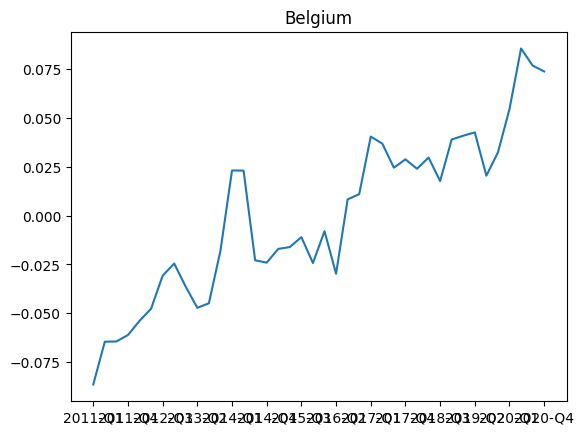

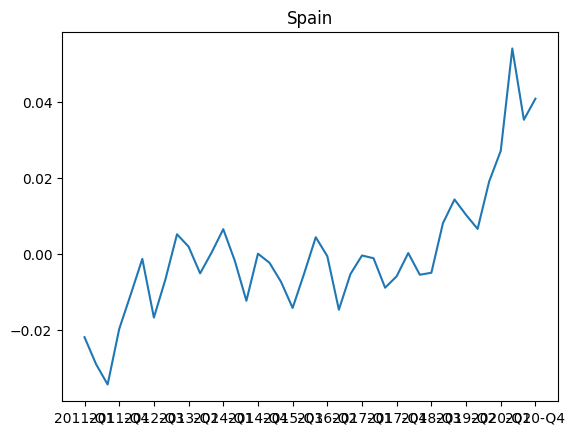

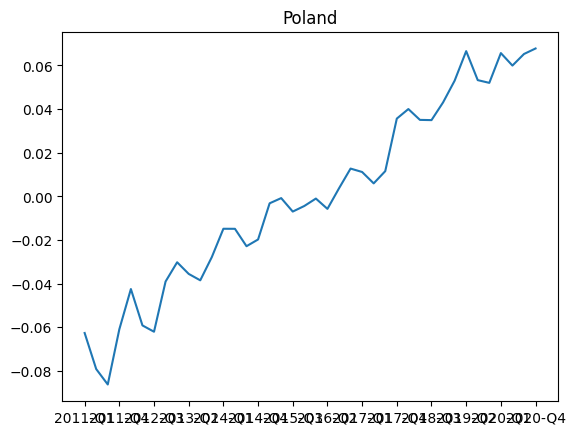

In [36]:
# The next step is to calculate the `classic` task content intensity, i.e.
# how important is a particular general task content category in the workforce
# Here, we're looking at non-routine cognitive analytical tasks, as defined
# by David Autor and Darron Acemoglu:


agg_list = []
for c in country_list:
    combined[f"{c}_NRCA"] = 0
    for t in task_list:
        combined[f"{c}_NRCA"] += combined[f"std_{c}_{t}"]

    # And we standardise NRCA in a similar way.
    temp_mean = np.average(combined[f"{c}_NRCA"], weights=combined[f"share_{c}"])
    temp_sd = np.sqrt(np.average((combined[f"{c}_NRCA"] - temp_mean)**2, weights=combined[f"share_{c}"]))
    combined[f"std_{c}_NRCA"] = (combined[f"{c}_NRCA"] - temp_mean) / temp_sd


# Finally, to track the changes over time, we have to calculate a country-level mean
# Step 1: multiply the value by the share of such workers.
    combined[f"multip_{c}_NRCA"] = combined[f"std_{c}_NRCA"] * combined[f"share_{c}"]

# Step 2: sum it up (it basically becomes another weighted mean)
    agg_list.append((c,combined.groupby(["TIME"])[f"multip_{c}_NRCA"].sum().reset_index()))
# We can plot it now!

for a in agg_list:
    plt.plot(a[1]["TIME"], a[1][f"multip_{a[0]}_NRCA"])
    plt.xticks(range(0, len(a[1]), 3), a[1]["TIME"][::3])
    plt.title(a[0])
    plt.show()

# If this code gets automated and cleaned properly,
#  you should be able to easily add other countries as well as other tasks.
# E.g.:

# Routine manual
# 4.A.3.a.3	Controlling Machines and Processes
# 4.C.2.d.1.i	Spend Time Making Repetitive Motions
# 4.C.3.d.3	Pace Determined by Speed of Equipment
